# Zonal averaged Surface CO2 upward flux

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
from scipy.io import loadmat
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
from scipy.io import netcdf
import netCDF4 as nc


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

## Area

In [3]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [4]:
# pick first member in case there are multiple members
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr

['GFDL-ESM4.gr.historical.Ofx']

## Get datasets and calculate variables

In [43]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc')
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc')
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc')
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc')
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc')
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc')
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc')
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc')
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc')
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc')
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc')
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc')
# A = xr.open_mfdataset('AREA.nc')

In [6]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

## Reassign coords in `dd` so that it matches up with coords from `areacello`

In [44]:
newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 180)>
 array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
        -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
        -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
        -19.5, -18.5, -17.5, -16.5,

In [45]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

## Dictionary for plot colors

In [9]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Plot plot plot

In [11]:
# define an A 
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello
A2 = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello.mean(['x'],keep_attrs=True)

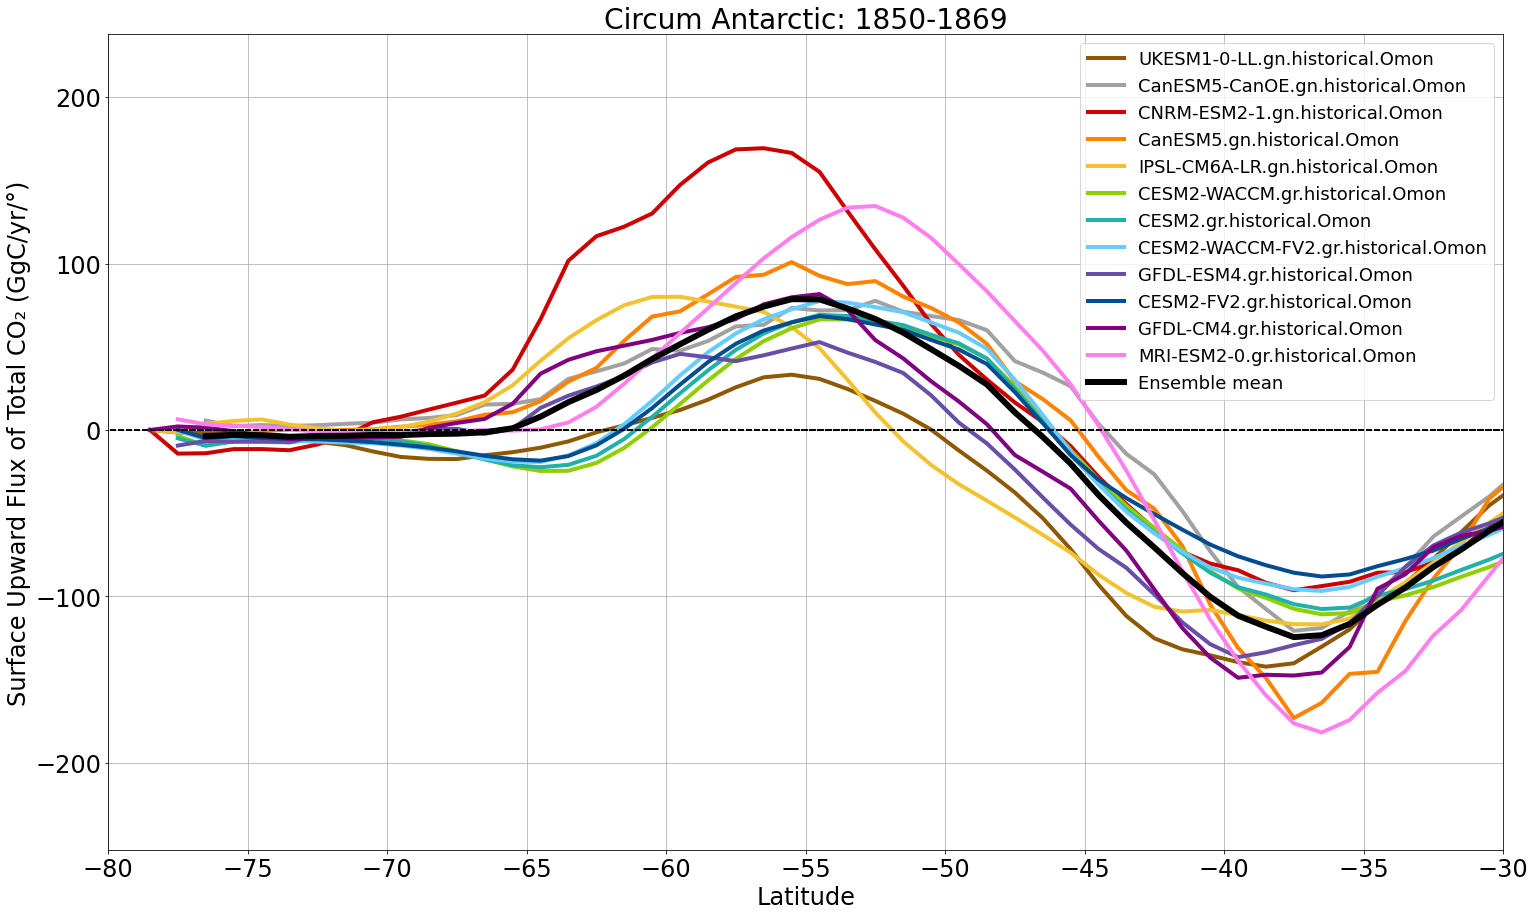

In [13]:
plt.rc('font', size = 24)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 24)
plt.rc('figure', titlesize=24)

temp = {}

conversion = 3.1536e7 * 83.3
for name, ds in dd.items():
    # multiply by conversion and A
    # multiply by -1 so it is surf UPWARD flux
    d = -1*ds.fgco2*A*conversion*12/1e9
    d = d.mean(['x'],keep_attrs=True)
    ar = d
    # d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    # # d = d.mean(['x'],keep_attrs=True)*conversion
    # ar = d*A2
    
    # put into a temp array so I can eventually take a mean of temp members
    temp[name]=ar
    
# plots the individual models .sel(y = slice(-80, -30))
for name, ds in temp.items():
    plt.plot(ds.y, ds, label = name, lw = 4, **model_kwargs[name])
    # plt.xlabel('Latitude')
    # plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

# take the mean of temp and plot
mn = np.mean(list(temp.values()), axis=0)
plt.plot(ds.y, mn, lw = 6, label = 'Ensemble mean', color = 'black')
# plt.xlabel('Latitude')
# plt.ylabel('Surface Upward Flux of Total CO\u2082 (molC/m\u00b2/yr)')

zr = xr.zeros_like(dd['CESM2-FV2.gr.historical.Omon'].fgco2)
plt.plot(zr.y, zr, linestyle = 'dashed', color = 'black')
plt.xlabel('Latitude', fontsize = 24)
plt.ylabel('Surface Upward Flux of Total CO\u2082 (GgC/yr/\u00b0)', fontsize = 24)
plt.xlim([-80,-30])
plt.xticks([-80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30])
plt.grid()
# plt.ylim([-5e19, 5e19])
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right', fontsize = 18
#     , borderaxespad=0.
)
plt.title('Circum Antarctic: 1850-1869', fontsize = 28)
plt.rcParams["figure.figsize"] = (25,15)

In [13]:
# define an A 
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello
A2 = dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello.mean(['x'],keep_attrs=True)
conversion = 3.1536e7 * 83.3
temp = {}
for name, ds in dd.items():
    # multiply by conversion and A
    # multiply by -1 so it is surf UPWARD flux
    d = -1*ds.fgco2*A*conversion*12/1e15
    d = d.mean(['x'],keep_attrs=True)
    ar = d
    # d = -1*ds.fgco2.mean(['x'],keep_attrs=True)*conversion
    # # d = d.mean(['x'],keep_attrs=True)*conversion
    # ar = d*A2
    
    # put into a temp array so I can eventually take a mean of temp members
    temp[name]=ar

In [14]:
r = temp['CESM2-FV2.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)


6.8481364e-05

In [89]:
indices = np.where(r > 0)
indices
# r.isel(y = 18)
# r.isel(y = 29)


(array([ 2, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [15]:
r = temp['CESM2-WACCM-FV2.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

7.747976e-05

In [91]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 25)

indices = np.where(r > 0)
indices

(array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [16]:
r = temp['CESM2-WACCM.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

6.646849e-05

In [93]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 25)

indices = np.where(r > 0)
indices

(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [17]:
r = temp['CESM2.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

6.918972e-05

In [95]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 25)

indices = np.where(r > 0)
indices

(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [18]:
r = temp['CNRM-ESM2-1.gn.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

0.00016931775761576731

In [97]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 23)

indices = np.where(r > 0)
indices

(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33]),)

In [19]:
r = temp['CanESM5-CanOE.gn.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

7.76004359326552e-05

In [99]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 27)

indices = np.where(r > 0)
indices

(array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]),)

In [20]:
r = temp['CanESM5.gn.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

0.0001008776356696396

In [101]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 24)

indices = np.where(r > 0)
indices

(array([ 6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),)

In [21]:
r = temp['GFDL-CM4.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

8.165789e-05

In [103]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 25)

indices = np.where(r > 0)
indices

(array([ 2,  3, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31]),)

In [22]:
r = temp['GFDL-ESM4.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

5.280483e-05

In [105]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 25)

indices = np.where(r > 0)
indices

(array([11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30]),)

In [23]:
r = temp['IPSL-CM6A-LR.gn.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

8.00575959941764e-05

In [107]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 20)

indices = np.where(r > 0)
indices

(array([11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30]),)

In [24]:
r = temp['MRI-ESM2-0.gr.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

0.00013458596

In [109]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 27)

indices = np.where(r > 0)
indices

(array([ 2,  3,  4,  5,  6, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35]),)

In [25]:
r = temp['UKESM1-0-LL.gn.historical.Omon'].sel(y = slice(-80, -30))
np.nanmax(r.values)

3.320352645403985e-05

In [111]:
# indices = np.where(r == np.nanmax(r.values))
# # indices
# r.isel(y = 24)

indices = np.where(r > 0)
indices

(array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),)

## Total outgassed CO2
Just summing the area integrated flux where it is positive (above)

In [63]:
fgco2_sums = {}

for name, ds in dd.items():
    ds = ds.sel(y = slice(-80, -40))
    ds = -1*ds.fgco2*A*conversion*12
    fgco2_sums[name] = sum(sum(np.where(ds>0, ds, 0)))/1e9
    # plt.plot(ds.y, np.where(ds>0, ds, 0))
    # fgco2_sums[name]
    

# sum(res)
fgco2_sums


{'UKESM1-0-LL.gn.historical.Omon': 140364.7246367947,
 'CanESM5-CanOE.gn.historical.Omon': 436578.8493114173,
 'CNRM-ESM2-1.gn.historical.Omon': 790187.5675324877,
 'CanESM5.gn.historical.Omon': 492329.9925803828,
 'IPSL-CM6A-LR.gn.historical.Omon': 357163.83194763085,
 'CESM2-WACCM.gr.historical.Omon': 303507.334194176,
 'CESM2.gr.historical.Omon': 313841.036852832,
 'CESM2-WACCM-FV2.gr.historical.Omon': 351543.31991808,
 'GFDL-ESM4.gr.historical.Omon': 301005.077057536,
 'CESM2-FV2.gr.historical.Omon': 312060.295447552,
 'GFDL-CM4.gr.historical.Omon': 444875.7161984,
 'MRI-ESM2-0.gr.historical.Omon': 583448.895258624}

In [43]:

clrs = {'UKESM1-0-LL.gn.historical.Omon': '#8f5904',
        'CanESM5-CanOE.gn.historical.Omon': '#a1a1a1',
        'CNRM-ESM2-1.gn.historical.Omon': '#cc0000',
        'CanESM5.gn.historical.Omon':'#ff8200',
        'IPSL-CM6A-LR.gn.historical.Omon': '#f1c232',
        'CESM2-WACCM.gr.historical.Omon': '#8fce00',
        'CESM2.gr.historical.Omon': '#20b2aa',
        'CESM2-WACCM-FV2.gr.historical.Omon': '#66ccff',
        'GFDL-ESM4.gr.historical.Omon': '#674ea7',
        'CESM2-FV2.gr.historical.Omon': '#024c8f',
        'GFDL-CM4.gr.historical.Omon': '#800080',
        'MRI-ESM2-0.gr.historical.Omon': '#ff80ed',
        'Average': 'k'}

clr = ['#8f5904',
        '#a1a1a1',
        '#cc0000',
        '#ff8200',
        '#f1c232',
        '#8fce00',
        '#20b2aa',
        '#66ccff',
        '#674ea7',
        '#024c8f',
        '#800080',
        '#ff80ed',
        'k'
        ]

Text(0, 0.5, 'Total CO₂ Outgas (PgC/yr)')

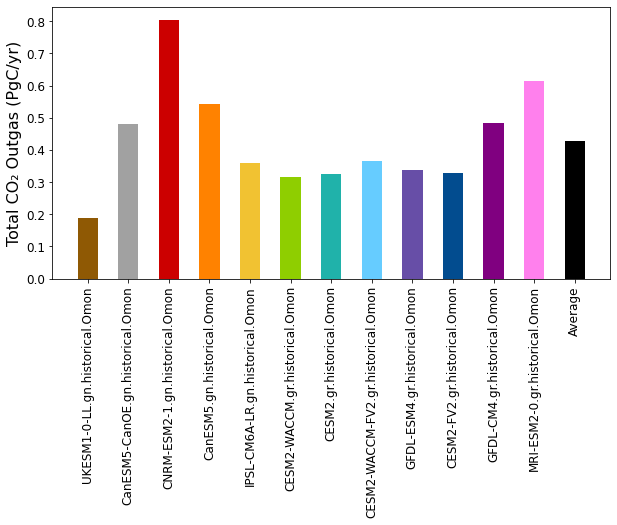

In [44]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

fgco2_sums_avg=list(fgco2_sums.values())
tot_avg = np.mean(fgco2_sums_avg)
fgco2_sums['Average'] = tot_avg

models = list(fgco2_sums.keys())
values = list(fgco2_sums.values())
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(models,values,
        width = 0.5, color = clr)
plt.xticks(rotation = 90)
# plt.xlabel("CMIP6 Models")
plt.ylabel('Total CO\u2082 Outgas (PgC/yr)')
# plt.title("Students enrolled in different courses")
# plt.show()

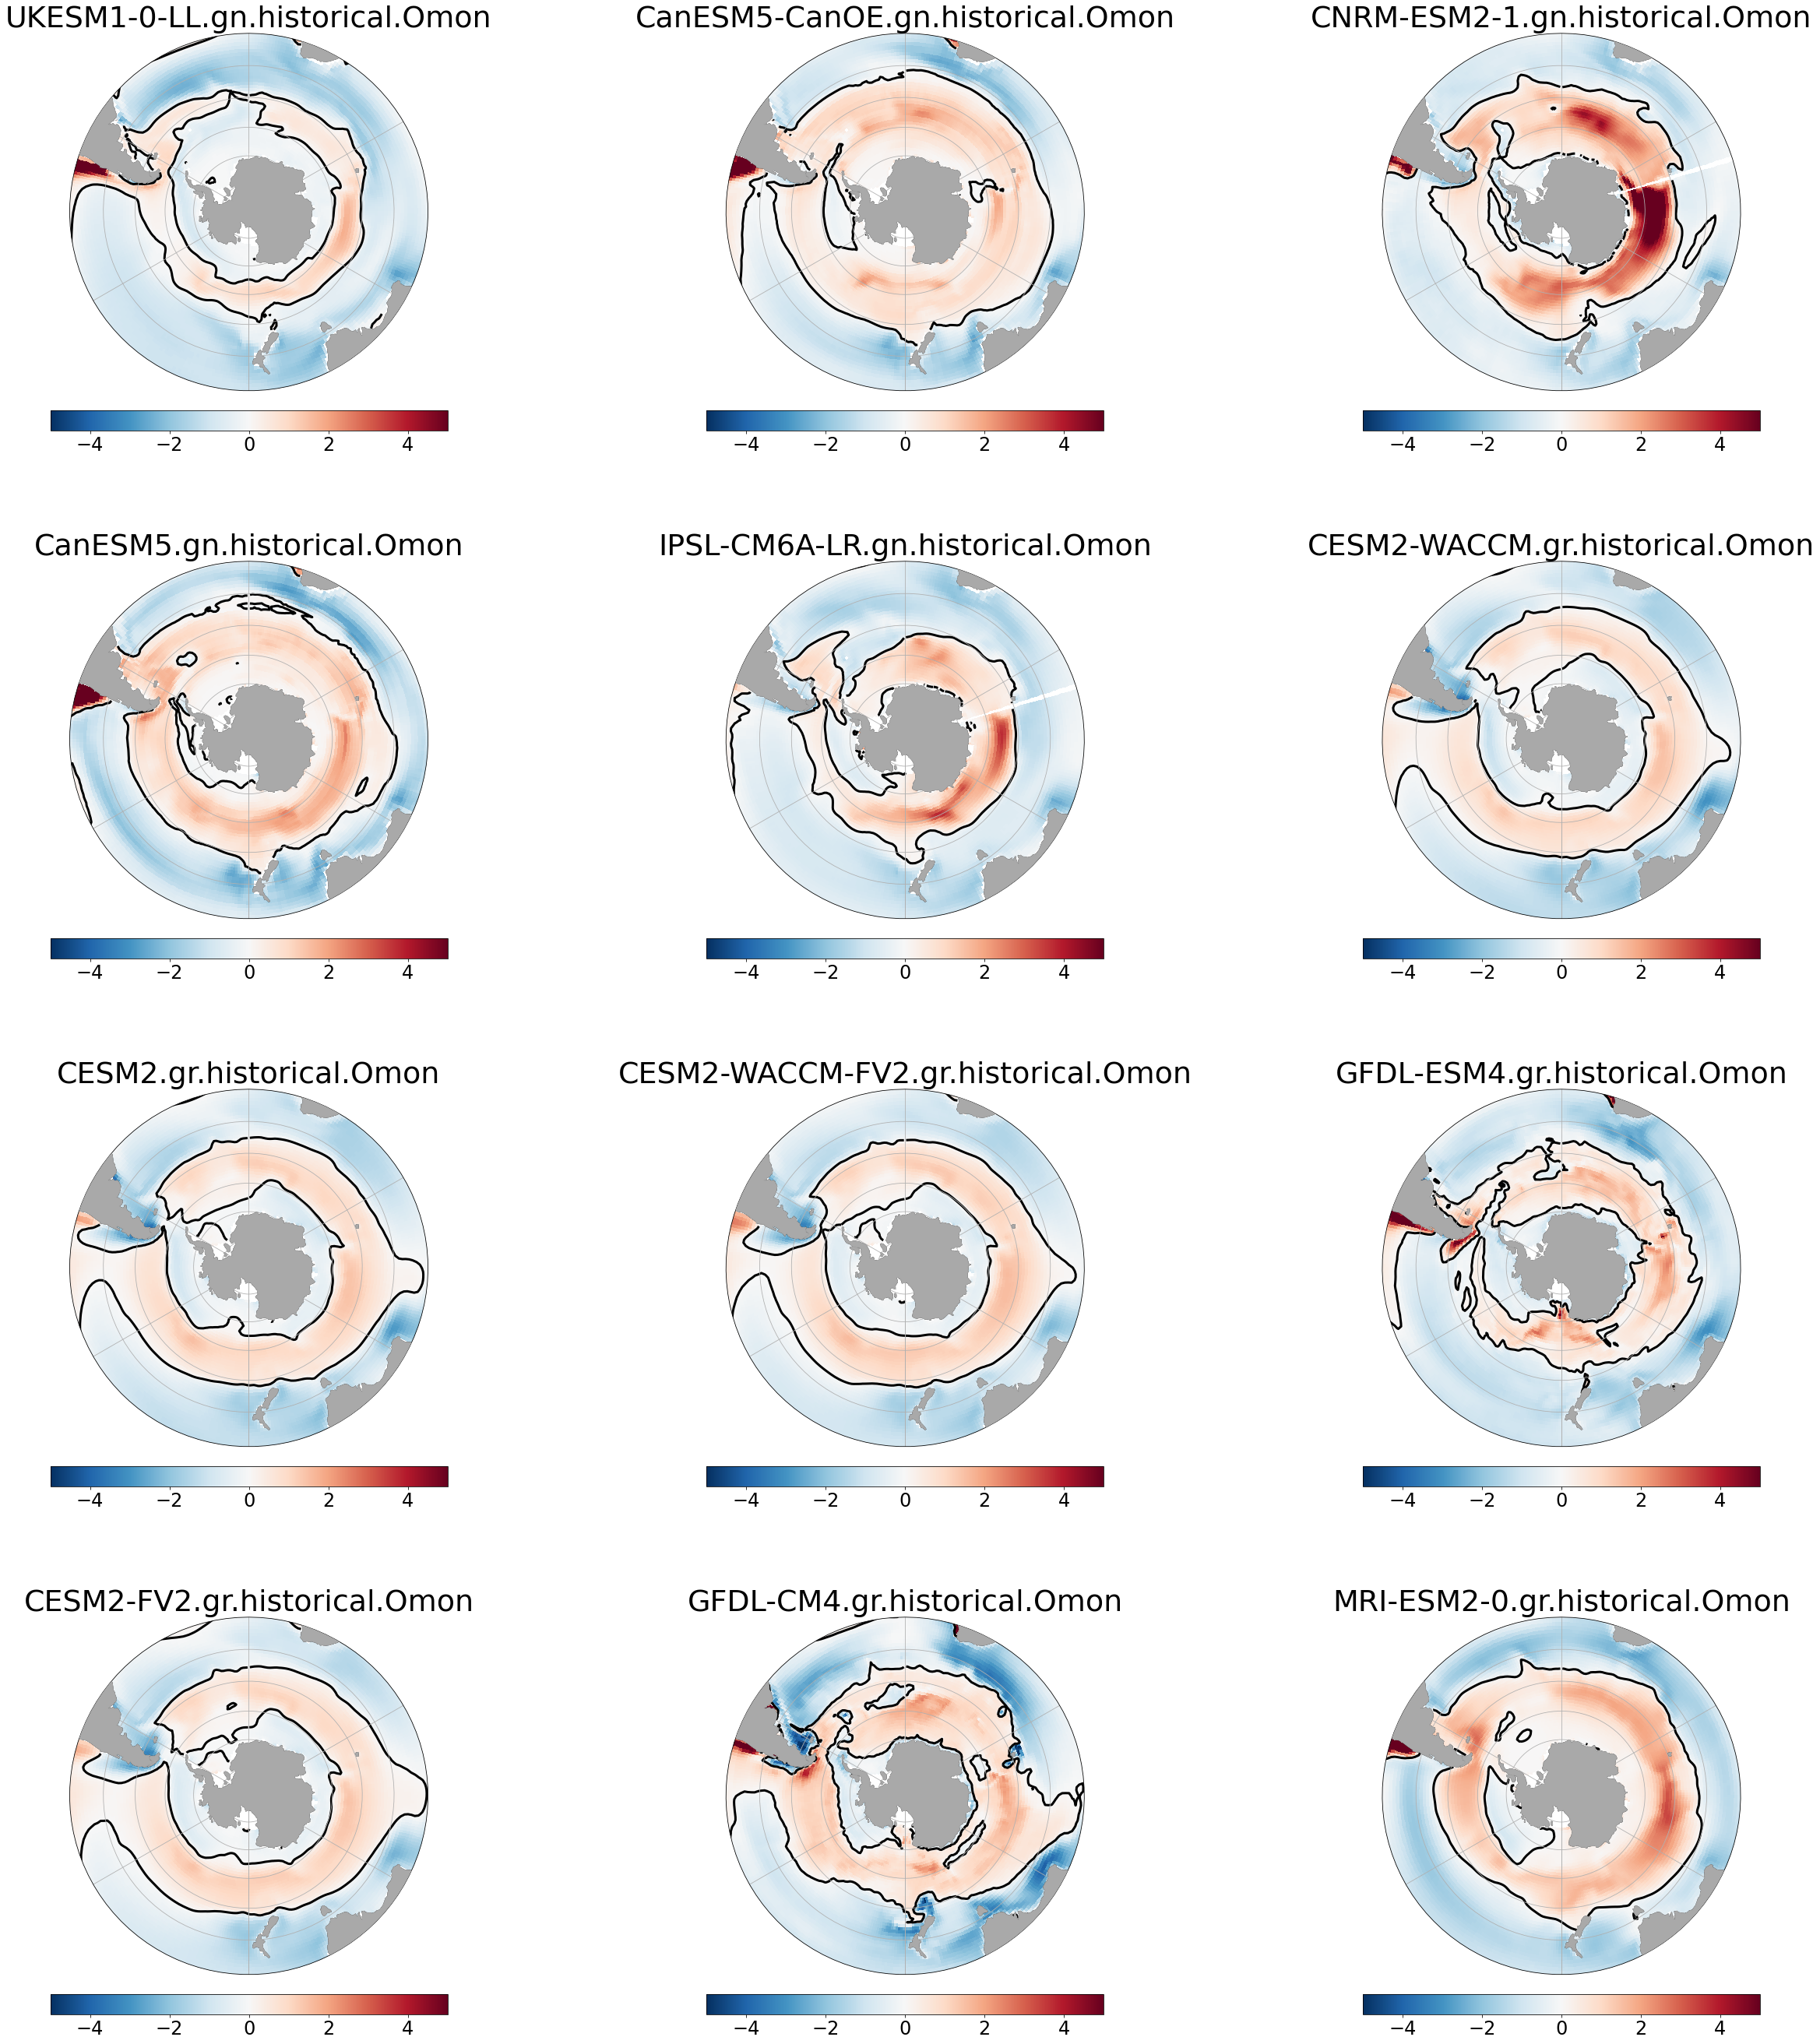

In [65]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40], subplot_kw={'projection':ccrs.SouthPolarStereo()})
fig.tight_layout(pad = 7)
crs_plot = ccrs.SouthPolarStereo()
crs_source = ccrs.PlateCarree()

ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    #fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    title=name
    ax.set_title(title,fontsize=38,pad = 1)
    
    lat = ds['fgco2'].lat.transpose('y','x')
    lon = ds['fgco2'].lon.transpose('y','x')
    X = lon
    Y = lat
    
    conversion = 3.1536e7 * 83.3
    # 3.1536e7 seconds per year
    # 83.3 mol C per kg -- 12 gC/mol
    
    Z = ds['fgco2']*conversion

#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
#     rho = rho.transpose('x','y')
#     rho.assign_coords({'lat': Y})
#     rho.assign_coords({'lon': X})
# #     rho = rho.transpose('y','x')
# #     print(Z)
# #     print(rho)
    
    
    im = ax.pcolormesh(X,Y,-1*Z,cmap='RdBu_r', transform = crs_source, shading = 'auto', vmin = -5, vmax = 5)
    im3 = ax.contour(X,Y,Z, transform = crs_source, levels=[0],colors='k', linewidths = 3)
    # if name == 'UKESM1-0-LL.gn.historical.Omon' or name =='CanESM5-CanOE.gn.historical.Omon' or name =='CNRM-ESM2-1.gn.historical.Omon' or name == 'CanESM5.gn.historical.Omon' or name == 'IPSL-CM6A-LR.gn.historical.Omon':
    #     CS = ax.contour(rho.lon,rho.lat,rho,transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    # else:
    #     CS = ax.contour(rho.lon.transpose('y','x'),rho.lat.transpose('y','x'),rho.transpose('y','x'),transform=crs_source,levels=[26.5, 27, 27.3],colors='g', linewidths = 3)
    
    cbar_label = 'Surface Upward Flux of Total CO\u2082 (mol/m\u00b2/yr)'
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
#     cbar.set_label(cbar_label, fontsize = 20)
#     cbar.ax.tick_params(labelsize=18)
#     ax.clabel(CS, inline=1, fontsize=24)
    
    ax_idx += 1


In [37]:
fgco2_sums = fgco2
for name, ds in fgco2_sums.items():
    
    


0.18847742746289844
0.4792083581983667
0.8049978498204003
0.5420173543997939
0.35917280482936204
0.316032949306368
0.324266957241952
0.366219245286912
0.337091567239168
0.326929445663744
0.483340823789568
0.614100866465792


In [47]:
d = dd['GFDL-CM4.gr.historical.Omon']
d['area'] = A
d

<xarray.Dataset>
Dimensions:  (y: 180, lev: 35, x: 360)
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
Data variables:
    dissic   (lev, y, x) float32 dask.array<chunksize=(35, 180, 360), meta=np.ndarray>
    fgco2    (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    so       (lev, y, x) float32 dask.array<chunksize=(35, 180, 360), meta=np.ndarray>
    talk     (lev, y, x) float32 dask.array<chunksize=(35, 180, 360), meta=np.ndarray>
    thetao   (lev, y, x) float32 dask.array<chunksize=(35, 180, 360), meta=np.ndarray>
    area     (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>

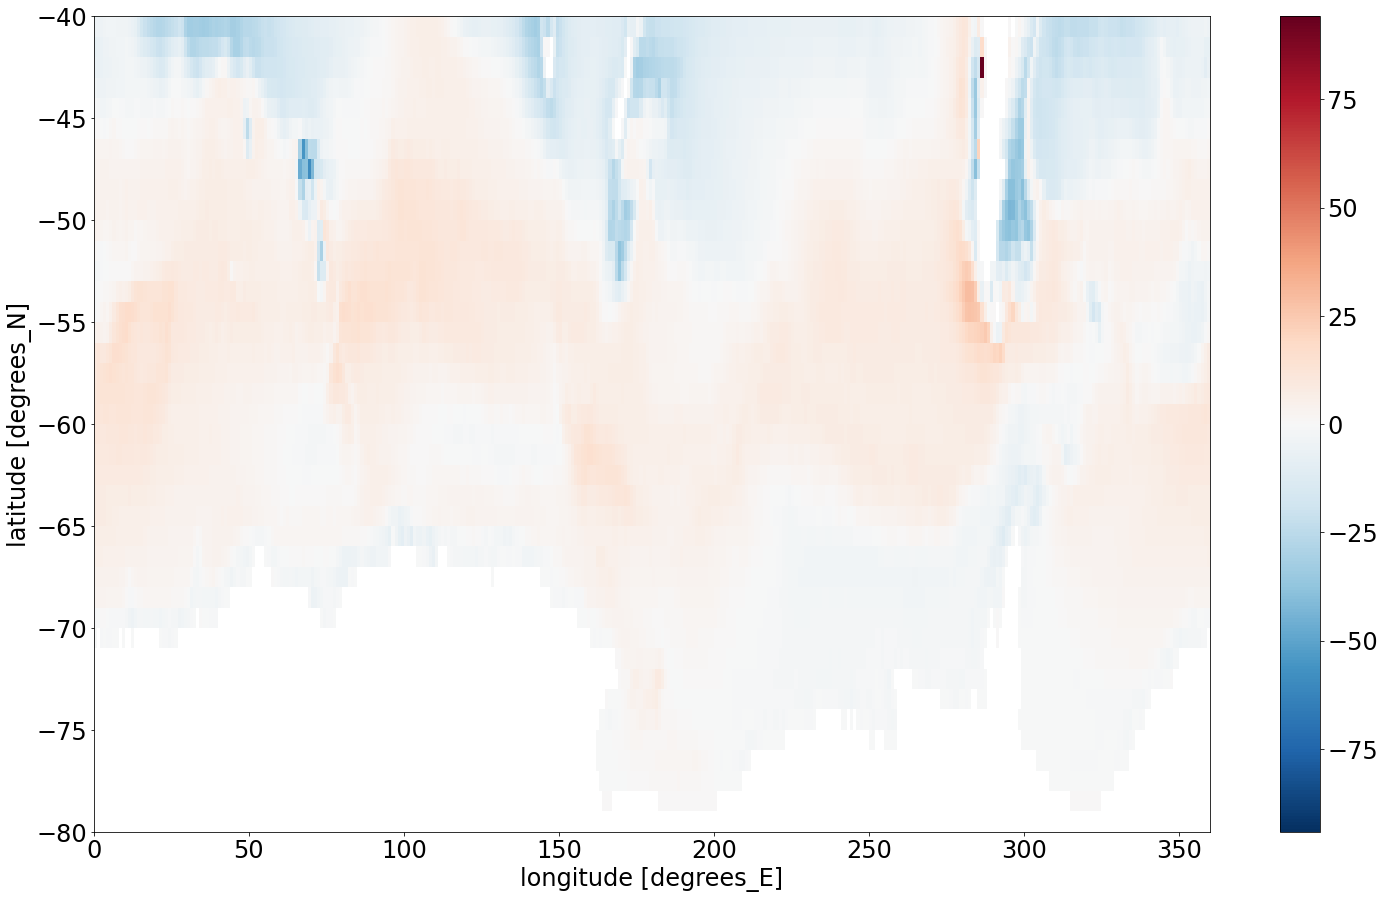

In [84]:
ds = dd['GFDL-CM4.gr.historical.Omon']
(-1*ds.fgco2*conversion*A/1e9).sel(y = slice(-80,-40)).plot()
# d9 = ((-1*ds['fgco2']*conversion*12*A)/1e9).sel(y = slice(-80,-40)).sum()/A.sel(y = slice(-80,-40)).sum()
# d9.where(d9 > 0).plot()

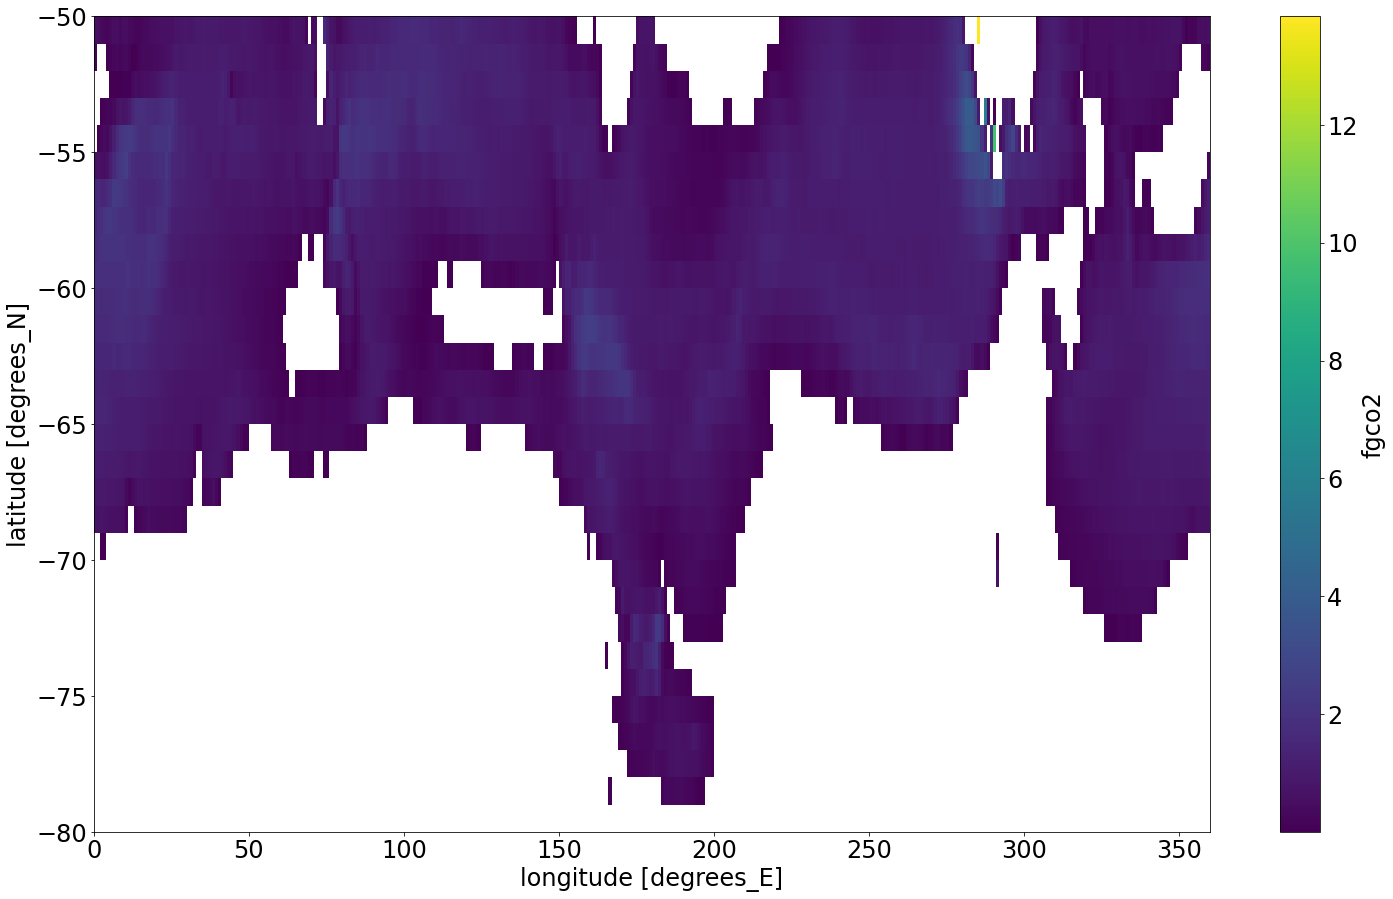

In [61]:
d3 = -1*d2.fgco2*conversion
d3.plot()

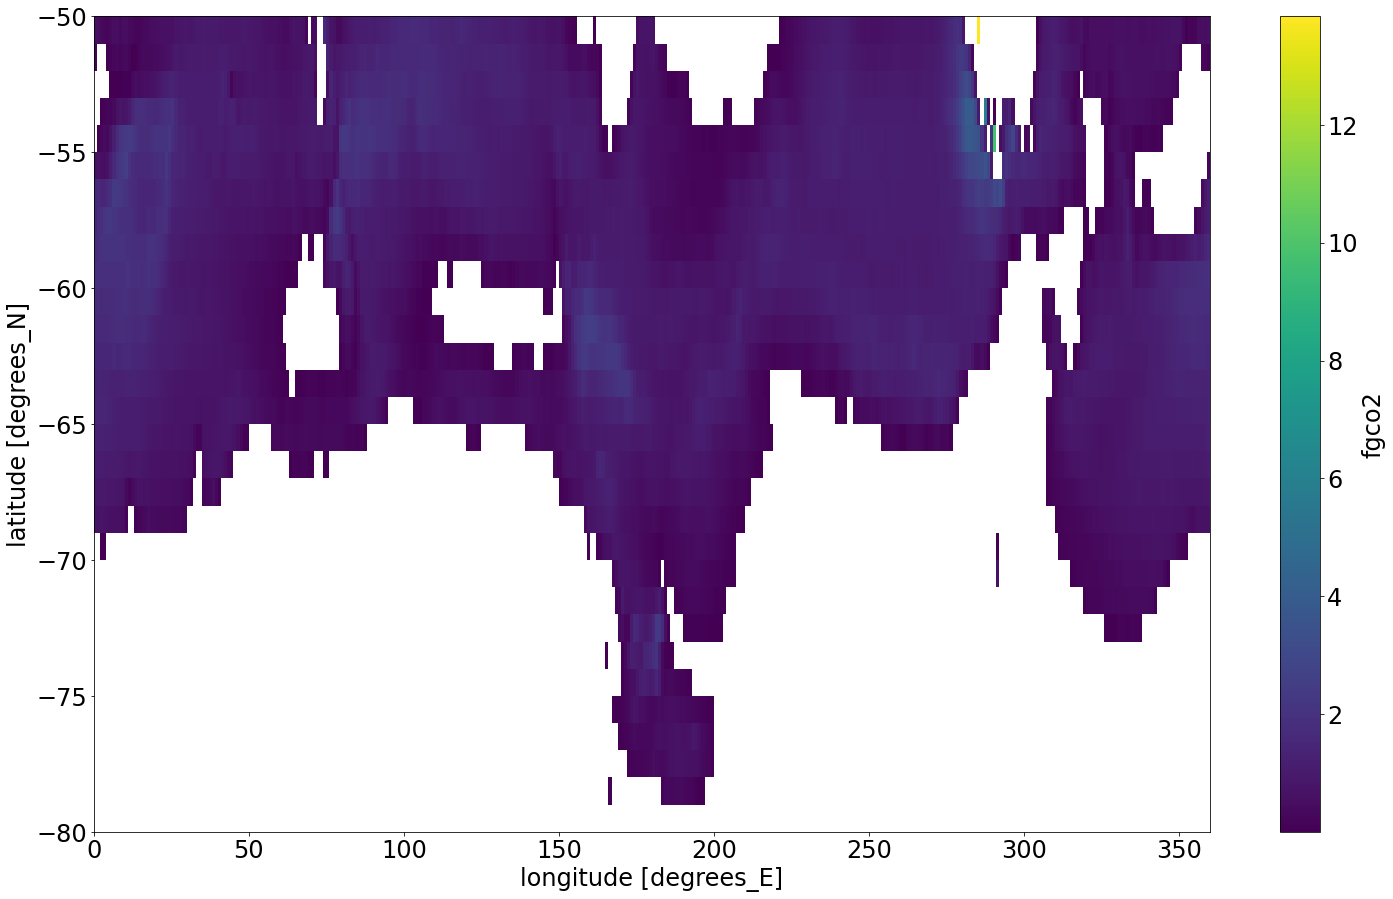

In [60]:
(-1*d2.fgco2*conversion).plot()

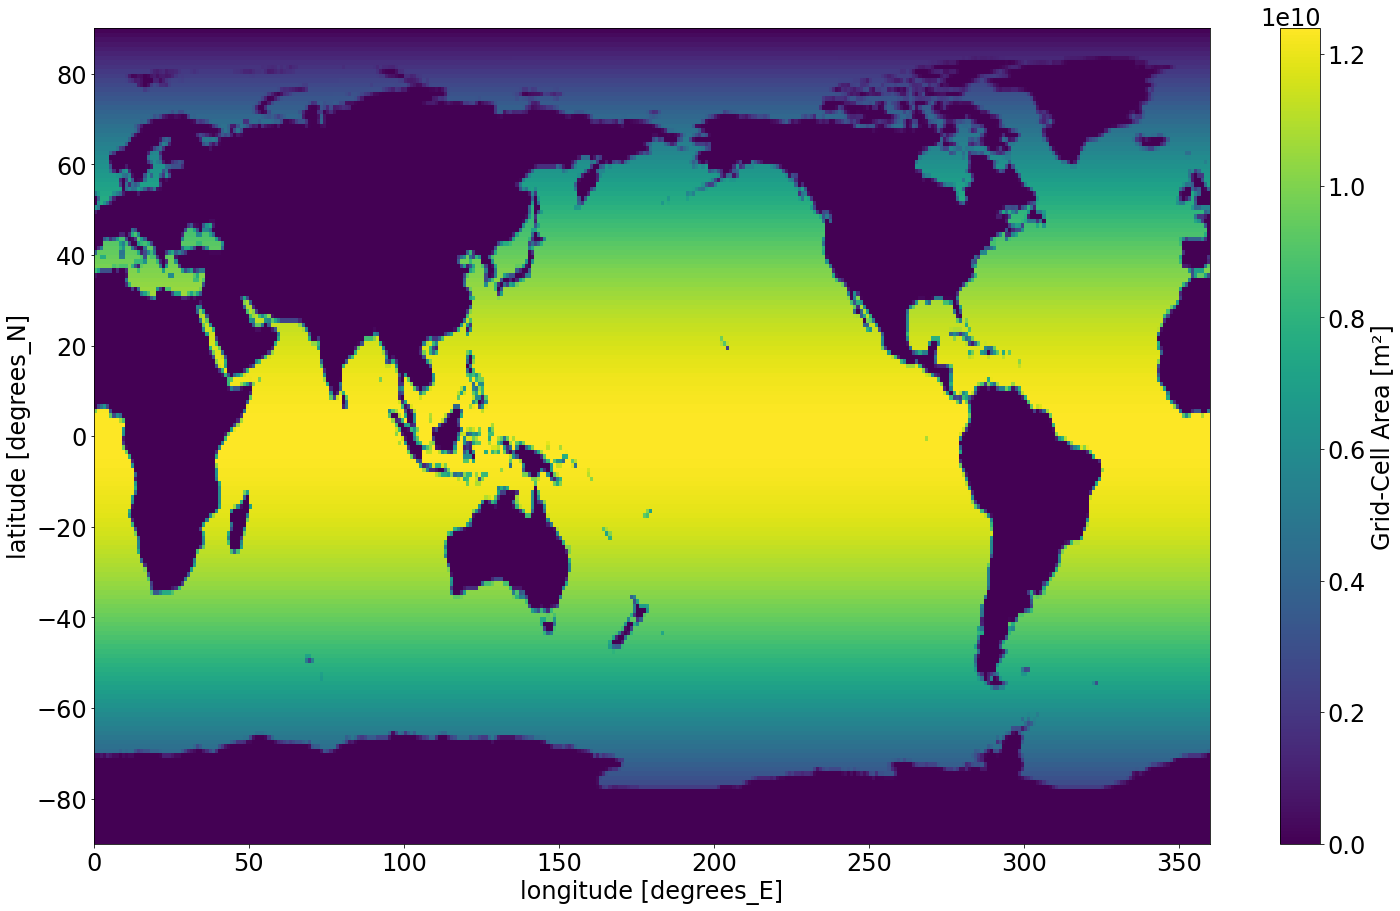

In [50]:
d.area.plot()